# Homework 2 (HW2)

By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

## Important Dates

- Homework release: Fri 18 Nov 2022
- **Homework due**: Fri 02 Dec 2022, 23:59
- Grade release: Mon 12 Dec 2022

---

##  Some rules

1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.
2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)
3. Be sure to provide a textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation (**in markdown**).
5. Back up any hypotheses and claims with data, since this is an important aspect of the course.
6. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, we will **not grade** anything.
7. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
8. In continuation to the previous point, interactive plots, such as those generated using `plotly`, should be **strictly avoided**!
9. Make sure to print results or dataframes that confirm you have properly addressed the task.

---

## Context

Congratulations! You have just been hired as a data scientist at [FC Tokyo, a J1 League Japanese professional football club based in Chōfu, Tokyo](https://en.wikipedia.org/wiki/FC_Tokyo). The company hired you to carry out a variety of data-related tasks, which will be explained in further detail below.

Your manager, Mr. Naoki Ogane, has noticed that an unusually high number of players in your team have birthdays in either April or May, so he asked you to investigate this further -- is this just a coincidence, or are players born in April or May simply better?

## Data

To answer Mr. Ogane's questions, you will use data from Wikipedia biographies. This is a subset of the Pantheon dataset (1). For tasks 1 to 4, you will use the file `japanese_athletes.csv.gz`. For task 5, you will use the file `all_entities.csv.gz`. Both datasets are`.csv` files with the same columns:

- `id`: a unique identifier per individual.
- `name`: name of the individual.
- `occupation`: the occupation of the individual (for `japanese_athletes.csv.gz`, these are all sports-related).
- `gender`: gender of the athlete.
- `alive`: flag indicating if the athlete was alive in 2020 when the dataset was collected.
- `bplace_country`: the country where the athlete was born  (for `japanese_athletes.csv.gz`, the value here is always 'Japan').
- `birthdate`: the date when the athlete was born.
- `birthyear`: the year when the athlete was born.
- `pageviews`: number of pageviews received by the athlete's page across Wikipedia language editions.

(1) Yu, A. Z., et al. (2016). Pantheon 1.0, a manually verified dataset of globally famous biographies. Scientific Data 2:150075. doi: 10.1038/sdata.2015.75

In [152]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from scipy import stats
import statsmodels.formula.api as smf

## Task 1 — 20 pts

As a good data scientist, you first load the data and perform some small sanity checks on it.

**1.1** Load the dataset containing data about Japanese athletes into memory using pandas. First, load the data directly from the compressed file. Then, print the first few lines of the dataset.

**1.2** Find the different occupations in the data and how many individuals belong to each occupation.

**1.3** Calculate the percentage of individuals who remain alive in the data.

**1.4** Plot the distribution of birth years in the dataset. In other words, what fraction of individuals are born each year? (Note that the data contains individuals born only after the year 1900).

**1.5** Plot the empirical cumulative distribution function (CDF) to visualize the distribution of pageviews. Here you should use a linear scale for both the x-axis and the y-axis.

**1.6** **Discuss:** why is it hard to visualize the distribution in the above ECDF plot?

**1.7** Re-do the above CDF plot using a log scale for both the x-axis and the y-axis. Additionally, plot vertical lines that indicate the distribution's arithmetic and geometric means.

**1.8** **Discuss:** Visually, does it look like the distribution is a power law?

**1.9** Estimate the 95% confidence intervals of the geometric mean and the arithmetic mean of pageviews using bootstrap resampling.

**1.10** **Discuss:** What advantages does the geometric mean have over the arithmetic mean to summarize the distribution?

### 1.1 Load the dataset

In [10]:
root = './'
data_root = os.path.join(root, 'data')
japanese_athletes = pd.read_csv(os.path.join(data_root, 'japanese_athletes.csv.gz'))
japanese_athletes.head()

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews
0,25864486,Hisataka Okamoto,SOCCER PLAYER,M,True,Japan,1933-12-14,1933.0,455.0
1,1682054,Kunishige Kamamoto,SOCCER PLAYER,M,True,Japan,1944-04-15,1944.0,57847.0
2,20639249,Akira Kitaguchi,SOCCER PLAYER,M,True,Japan,1935-03-08,1935.0,759.0
3,20641463,Tsukasa Hosaka,SOCCER PLAYER,M,False,Japan,1937-03-03,1937.0,1672.0
4,25864343,Takashi Kasahara,SOCCER PLAYER,M,True,Japan,1918-03-26,1918.0,541.0


### 1.2 Find the different occupations in the data and how many individuals belong to each occupation.

In [56]:
occupation_groupby = japanese_athletes.groupby('occupation')['id'].count().rename('count')
occupation_groupby

occupation
ATHLETE                40
BASKETBALL PLAYER       2
BOXER                   2
CYCLIST                 4
GYMNAST                15
SKATER                 21
SKIER                  11
SOCCER PLAYER        3929
SWIMMER                21
TENNIS PLAYER          18
WRESTLER               60
Name: count, dtype: int64

### 1.3 Calculate the percentage of individuals who remain alive in the data.

In [57]:
percentage_alive = japanese_athletes.alive.sum() / len(japanese_athletes)
print(f'The percentage of individuals who remain alive is {100 * percentage_alive}%.')

The percentage of individuals who remain alive is 97.18651467378123%.


### 1.4 Plot the distribution of birth years in the dataset. In other words, what fraction of individuals are born each year? (Note that the data contains individuals born only after the year 1900).


Text(0.5, 1.0, 'Number fraction against year')

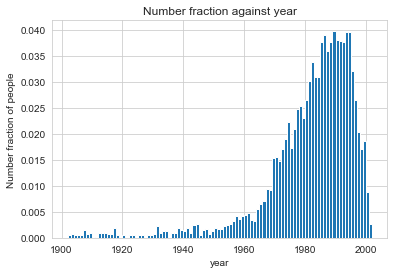

In [69]:
plt.hist(japanese_athletes.birthyear, bins=100, density=True)
plt.xlabel("year")
plt.ylabel('Number fraction of people')
plt.title('Number fraction against year')

### 1.5 Plot the empirical cumulative distribution function (CDF) to visualize the distribution of pageviews. Here you should use a linear scale for both the x-axis and the y-axis.

Text(0.5, 1.0, 'ECDF of pageviews')

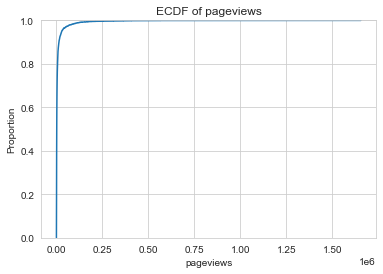

In [73]:
sns.ecdfplot(data=japanese_athletes.pageviews, )
plt.title("ECDF of pageviews")

### 1.6 Discuss: why is it hard to visualize the distribution in the above ECDF plot?

answer:
Because there are very few athletes with very high pageviews.

### 1.7 Re-do the above CDF plot using a log scale for both the x-axis and the y-axis. Additionally, plot vertical lines that indicate the distribution’s arithmetic and geometric means.

<AxesSubplot:xlabel='pageviews', ylabel='Proportion'>

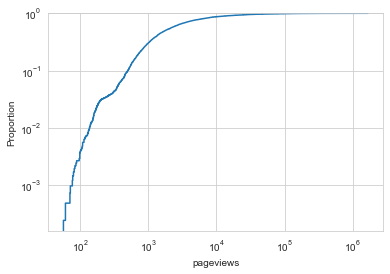

In [74]:
sns.ecdfplot(data=japanese_athletes.pageviews, log_scale=(True, True))

### 1.8 Discuss: Visually, does it look like the distribution is a power law?

answer: Yes it does.

### 1.9 Estimate the 95% confidence intervals of the geometric mean and the arithmetic mean of pageviews using bootstrap resampling.

In [83]:
print(stats.bootstrap((japanese_athletes.pageviews, ), np.mean, confidence_level=0.95))
print(stats.bootstrap((japanese_athletes.pageviews, ), stats.gmean, confidence_level=0.95))

BootstrapResult(confidence_interval=ConfidenceInterval(low=7669.515564182053, high=10346.340519834459), standard_error=645.7020923750823)
BootstrapResult(confidence_interval=ConfidenceInterval(low=2096.690036203427, high=2281.5786024879703), standard_error=47.011419768642654)


### 1.10 Discuss: What advantages does the geometric mean have over the arithmetic mean to summarize the distribution?

answer:
The geometric mean is less affected by extreme values in a skewed distribution.

## Task 2 — 20 pts

Next, investigate the question posed by Mr. Ogane. *Why do so many Tokyo FC players have birthdays in the same month?* 
Here you will not look specifically at Tokyo FC players, but more generally at the birthdays of the athletes in the dataset you have explored in Task 1

**2.1** Calculate and plot the distribution of births (among the athletes contained in the Wikipedia dataset) over months, i.e., what percentage of births happen in January, February, etc.

**2.2** Puzzled with the results, you use census data to retrieve the percentage of births happening each month (this is given to you in an array below). Plot this distribution.

**2.3** **Discuss:** what is different between the distributions you ploted in **2.1** and **2.2**

After discussing with your colleagues at work, a theory comes to your mind: school in Japan starts in April. Children who were born between April 1 and March 31 of the following year are placed within the same grade. Therefore, you suspect that the observed pattern may have something to do with when students start school.

**2.4** Considering that students in Japanese schools have the same birth distribution over the months of the year as the overall Japanese population, i.e., the `birth_per_month` array that was provided to you, calculate:

- For students born in April, how many months older are they than the average student in their grade?
- For students born in March, how many months younger are they than the average student in their grade?

**2.5** **Discuss:** Considering your common sense and the results obtained from the simulation: what advantage do students born in April have over those born in March? How may this affect their odds of becoming professional athletes?

### 2.1 Calculate and plot the distribution of births (among the athletes contained in the Wikipedia dataset) over months, i.e., what percentage of births happen in January, February, etc.

In [87]:
japanese_athletes['birthMonth'] = pd.DatetimeIndex(japanese_athletes.birthdate).month

Text(0, 0.5, 'Density')

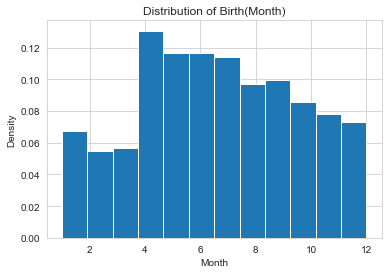

In [94]:
plt.hist(japanese_athletes.birthMonth, bins=12, density=True)
plt.title("Distribution of Birth(Month)")
plt.xlabel("Month")
plt.ylabel("Density")

### 2.2 Puzzled with the results, you use census data to retrieve the percentage of births happening each month (this is given to you in an array below). Plot this distribution.

Text(0, 0.5, 'Density')

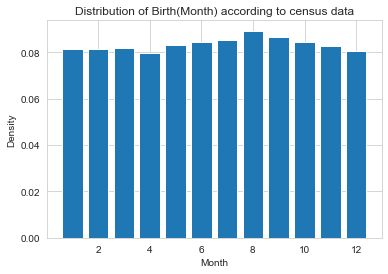

In [133]:
birth_per_month = np.array([
0.08118368,0.08148065, 0.08182577, 0.07982728, 0.08301363,
0.08422556, 0.08518067, 0.08925791, 0.08635247, 0.08460279,
0.08258825, 0.08046134
])
plt.bar(range(1,13), birth_per_month)
plt.title("Distribution of Birth(Month) according to census data")
plt.xlabel("Month")
plt.ylabel("Density")

### 2.3 Discuss: what is different between the distributions you ploted in 2.1 and 2.2
answer: The players born in April is of the highest number, however, there are least people born in April. While in August the result is reversed.

After discussing with your colleagues at work, a theory comes to your mind: school in Japan starts in April. Children who were born between April 1 and March 31 of the following year are placed within the same grade. Therefore, you suspect that the observed pattern may have something to do with when students start school.

### 2.4 Considering that students in Japanese schools have the same birth distribution over the months of the year as the overall Japanese population, i.e., the birth_per_month array that was provided to you, calculate:
For students born in April, how many months older are they than the average student in their grade?
For students born in March, how many months younger are they than the average student in their grade?

In [144]:
# A student born in April will be 11 months older than a student born in March, 10 months older than a student born in February.
age_diff_april = np.array([9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8])
avg_older = (age_diff_april * birth_per_month).sum()
print(f'For students born in April, they are {avg_older} months older than the average student in their grade.')
age_diff_march = np.array([2, 1, 0, 11, 10, 9, 8, 7, 6, 5, 4, 3])
avg_younger = (age_diff_march * birth_per_month).sum()
print(f'For students born in March, they are {avg_younger} months younger than the average student in their grade.')

For students born in April, they are 5.47076905 months older than the average student in their grade.
For students born in March, they are 5.52923095 months younger than the average student in their grade.


### 2.5 Discuss: Considering your common sense and the results obtained from the simulation: what advantage do students born in April have over those born in March? How may this affect their odds of becoming professional athletes?
answer: The student born in April are older than average, the advantage is especially significant when students are young.

## Task 3 — 20 pts

You report your findings to Mr. Ogane, who receives them with great interest. He asks you: *is there a causal effect between being older than your peers and becoming a Wikipedia-famous athlete?* (Here, “Wikipedia-famous” refers to those individuals notable enough to have made it into English Wikipedia.)

**3.1** Create a new column in the dataframe called `date_diff` representing the distance between the athlete's birthdate and the cutoff date of his school class. 
- For individuals born in April, May, June, July, August, and September: The distance should be positive and represent the number of days between the birthdate and the previous April 1. For example, if someone is born on April 1, the distance is 0, if someone is born on April 10, the distance is 9, etc.
- For individuals born in October, November, December, January, February, and March: The distance should be negative and represent the number of days between the following April 1 and the birthdate. For example, if someone is born on March 31, the distance is -1; if someone is born on March 27, the distance is -5.
- Print the `date_diff` for the athletes with ids:  `20639249` and `58982155`.

**3.2** Create three numpy arrays `x`, `y`, and `ind` all of size 360. 
- `x` should contain the integers between -180 and 179 (-180 and 179 inclusive). 
- `y` should contain the percentage of athletes born with a `date_diff` equal to the corresponding value of `x`.
- `ind` should contain 0 if `x` is smaller than zero and 1 if `x` is bigger or equal to zero.


**3.3** Estimate the following linear regression: `y ~ x + ind` using `statsmodels`. Report the summary of the model.

**3.4** **Discuss:** What does the coefficient associated with the dummy variable `ind` captures in the above regression?

**3.5** Use the model parameters to estimate the percentage of athletes born on March 31st, i.e., use the intercept ($\beta_0$) and the coefficient associated with `x` ($\beta_1$) and calculate: $\beta_0 - 1 * \beta_1$ (recall that $x$ equals -1 in March 31st).

**3.6** Use the model parameters to estimate the percentage of athletes born on April 1st.

**3.7** **Discuss:** Drawing from your knowledge of observational studies and the questions answered thus far, respond to Mr. Ogane's question: *is there a causal effect between being older than your peers and becoming a Wikipedia-famous athlete?* Explain whether the evidence you have obtained is convincing and why.

---

**Comment**: Note that in **3.2**, the size of the array created is slightly smaller than the number of days in the year. This is for simplicity's sake.

### **3.1** Create a new column in the dataframe called `date_diff` representing the distance between the athlete's birthdate and the cutoff date of his school class.
- For individuals born in April, May, June, July, August, and September: The distance should be positive and represent the number of days between the birthdate and the previous April 1. For example, if someone is born on April 1, the distance is 0, if someone is born on April 10, the distance is 9, etc.
- For individuals born in October, November, December, January, February, and March: The distance should be negative and represent the number of days between the following April 1 and the birthdate. For example, if someone is born on March 31, the distance is -1; if someone is born on March 27, the distance is -5.
- Print the `date_diff` for the athletes with ids:  `20639249` and `58982155`.

In [163]:
# construct a function to calculate the date difference
def calculate_diff(birthdate: str):
    datem = datetime.datetime.strptime(birthdate, "%Y-%m-%d")
    year_str = datem.strftime("%Y")
    month_str = datem.strftime("%m")
    if month_str in ['04', '05', '06', '07', '08', '09']:
        reference_str = year_str + '/04/01'
        reference_date = datetime.datetime.strptime(reference_str, "%Y/%m/%d")
        return (datem - reference_date).days
    else:
        if month_str in ['10', '11', '12']:
            reference_str = str(int(year_str)+1) + '/04/01'
        else:
            reference_str = year_str + '/04/01'
        reference_date = datetime.datetime.strptime(reference_str, "%Y/%m/%d")
        return (datem - reference_date).days

In [164]:
japanese_athletes['date_diff'] = japanese_athletes.birthdate.apply(lambda x: calculate_diff(x))

In [170]:
ids = [20639249, 58982155]
diff1 = japanese_athletes[(japanese_athletes.id == ids[0])]['date_diff'].to_list()[0]
print(f'The date difference is {diff1} for id {ids[0]}.')
diff2 = japanese_athletes[(japanese_athletes.id == ids[1])]['date_diff'].to_list()[0]
print(f'The date difference is {diff2} for id {ids[1]}.')

The date difference is -24 for id 20639249.
The date difference is 6 for id 58982155.


### **3.2** Create three numpy arrays `x`, `y`, and `ind` all of size 360.
- `x` should contain the integers between -180 and 179 (-180 and 179 inclusive).
- `y` should contain the percentage of athletes born with a `date_diff` equal to the corresponding value of `x`.
- `ind` should contain 0 if `x` is smaller than zero and 1 if `x` is bigger or equal to zero.

In [205]:
x = np.arange(-180, 180)
y = [japanese_athletes[japanese_athletes.date_diff==a]['id'].count() / len(japanese_athletes) for a in x]
ind = [1 if a >= 0 else 0 for a in x]
# print(len(x), len((y)), len(ind))

### **3.3** Estimate the following linear regression: `y ~ x + ind` using `statsmodels`. Report the summary of the model.

In [210]:
df_for_ols = pd.DataFrame({'x': x, 'y': y, 'ind': ind})
mod = smf.ols(formula="y ~ x + ind", data=df_for_ols)
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     118.8
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           2.87e-40
Time:                        19:26:30   Log-Likelihood:                 2019.2
No. Observations:                 360   AIC:                            -4032.
Df Residuals:                     357   BIC:                            -4021.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0015      0.000     14.696      0.000       0.001       0.002
x          -5.947e-06   9.03e-07     -6.583      0.000   -7.72e-06   -4.17e-06
ind            0.0024      0.000     12.669      0.000       0.002       0.003
==============================================================================
Omnibus:                       14.741   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.681
Skew:                           0.388   Prob(JB):                     0.000145
Kurtosis:                       3.760   Cond. No.                         468.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### **3.4** **Discuss:** What does the coefficient associated with the dummy variable `ind` captures in the above regression?
It captures the

### **3.5** Use the model parameters to estimate the percentage of athletes born on March 31st, i.e., use the intercept ($\beta_0$) and the coefficient associated with `x` ($\beta_1$) and calculate: $\beta_0 - 1 * \beta_1$ (recall that $x$ equals -1 in March 31st).

In [211]:
params = result.params
pred_3_5 = params[0] - params[1]
print(f'The prediction is {pred_3_5}')

The prediction is 0.0015536189430982589


### **3.6** Use the model parameters to estimate the percentage of athletes born on April 1st.

In [212]:
pred_3_6 = params[0] + params[1] + params[2]
print(f'The prediction is {pred_3_6}')

The prediction is 0.003920532326263221


### **3.7** **Discuss:** Drawing from your knowledge of observational studies and the questions answered thus far, respond to Mr. Ogane's question: *is there a causal effect between being older than your peers and becoming a Wikipedia-famous athlete?* Explain whether the evidence you have obtained is convincing and why.

answer: Maybe there is a causal effect between older than your peers and becoming a Wikipedia-famous athlete.

## Task 4 — 20 pts

You return to Mr. Ogane with your findings, which he again receives with great interest. The sharp manager, however, asks a question that ignites your curiosity: *are athletes that are born right after the school cut-off date (i.e., in April or May) simply better?**

To understand if that is the case, you come up with a plan: the number of pageviews received by a Wikipedia page is a good way to differentiate between mildly famous athletes and truly famous ones. Thus you can do a matched analysis comparing athletes born in February or March (right before the cut-off) with athletes born in April or May (right after the cut-off); you should discard all athletes that were not born in one of these four months.

To make matched athletes even more comparable, you will also only consider pairs of athletes that:
1. were born in the same year; 
2. have the same gender; and
3. have the same occupation.

Matching should be done 1-to-1; i.e., each athlete born in February/March should be matched to one and only one athlete born in April/May (there will naturally be some athletes left unmatched).

**4.1** Obtain the matched data described in the text above. Report the number of matched pairs and the number of discarded athletes. Your resulting dataframe should contain one row per athlete and an indicator variable `is_after`, which equals 1 when the athlete was born in April or May and 0 otherwise. Note that here you are doing exact matching, and not propensity score matching!

**4.2** The number of pageviews is heavy-tailed, as we have seen in Task 1. Create a new column in your matched dataframe containing the natural logarithm of the number of pageviews.

**4.3** Assuming that whether the athlete is born in the two months right before the cutoff (February and March) or the two months right after (April and May) is assigned at random, use a linear regression to estimate the effect of being born after rather than before the cutoff date in the number of pageviews athletes receive. Use the log-transformed value you calculated in **4.2** as the outcome of your model (i.e., the $y$ of the regression). Report the summary of your model.


**4.4** **Discuss:** Interpret the coefficients obtained from the linear regression.

**4.5** Interpreting the results obtained throughout this homework, create a short text (max. 250 words) where you:
- Present and explain a credible causal diagram capturing the relationship between the variables below, and justify your causal diagram given the questions answered in this homework:
    1. "Skill": an individual's innate talent towards a sport.
    2. "Relative Age": how old an individual was in comparison to his or her peers.
    3. "Success before adulthood": how successful the individual is as an athlete as a child/teenager.
    4. "Success as an adult": how successful the individual is as an athlete as an adult.
- **Discuss:** Consider two equally successful children athletes, one born on March 31 and the other on April 1 — which will likely be more successful as an adult? Your answer should be consistent with your causal diagram.

---


### 4.1 Obtain the matched data described in the text above. Report the number of matched pairs and the number of discarded athletes. Your resulting dataframe should contain one row per athlete and an indicator variable is_after, which equals 1 when the athlete was born in April or May and 0 otherwise. Note that here you are doing exact matching, and not propensity score matching!

In [346]:
# First we make a copy of the original dataframe, and delete the unneeded lines.
df4 = japanese_athletes.copy()
df4 = df4[~((df4.birthMonth < 2) | (df4.birthMonth > 5))]
df4['is_after'] = df4.birthMonth.apply(lambda x: x>=4)
before = df4[df4.is_after == 0].copy().reset_index(drop=True)
after = df4[df4.is_after == 1].copy().reset_index(drop=True)

In [408]:
def get_match(before, after):
    len_before = len(before)
    len_after = len(after)
    matched = np.zeros((len_after, 1))
    matched_df = pd.DataFrame()
    first = 1
    for i in range(len_before):
        row_i = before.iloc[i]
        row_i = pd.Series(row_i, ['id', 'name', 'occupation', 'gender', 'alive', 'bplace_country', 'birthdate', 'birthyear', 'pageviews', 'birthMonth', 'date_diff', 'is_after'])
        for j in range(len_after):
            row_j = after.iloc[j]
            row_j = pd.Series(row_j, ['id', 'name', 'occupation', 'gender', 'alive', 'bplace_country', 'birthdate', 'birthyear', 'pageviews', 'birthMonth', 'date_diff', 'is_after'])
            if matched[j]:
                continue
            if row_j.birthyear == row_i.birthyear:
                if row_j.gender == row_i.gender:
                    if row_j.occupation == row_i.occupation:
                        matched[j] = 1
                        matched_row = pd.DataFrame(pd.concat([row_i, row_j])).T
                        if first:
                            # matched_df = pd.DataFrame('0', index=range(0), columns=['id', 'name', 'occupation', 'gender', 'alive', 'bplace_country', 'birthdate', 'birthyear', 'pageviews', 'birthMonth', 'date_diff', 'is_after', 'id2', 'name2', 'occupation2', 'gender2', 'alive2', 'bplace_country2', 'birthdate2', 'birthyear2', 'pageviews2', 'birthMonth2', 'date_diff2', 'is_after2'])
                            first = 0
                            matched_df = matched_row
                        else:
                            matched_df = pd.concat([matched_df, matched_row], axis=0)
                        break
                    else: continue
                else: continue
            else:continue
    return matched_df

In [409]:
matched_df = get_match(before, after)

In [413]:
matched_df.head()

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews,birthMonth,...,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews,birthMonth,date_diff,is_after
0,20641239,Yasuo Takamori,SOCCER PLAYER,M,False,Japan,1934-03-03,1934.0,1047.0,3,...,SOCCER PLAYER,M,False,Japan,1934-04-21,1934.0,758.0,4,20,True
0,733681,Kazuyoshi Miura,SOCCER PLAYER,M,True,Japan,1967-02-26,1967.0,496424.0,2,...,SOCCER PLAYER,M,True,Japan,1967-05-10,1967.0,50374.0,5,39,True
0,19134567,Masahiro Hamazaki,SOCCER PLAYER,M,False,Japan,1940-03-14,1940.0,983.0,3,...,SOCCER PLAYER,M,True,Japan,1940-05-28,1940.0,2431.0,5,57,True
0,20305413,Shigemaru Takenokoshi,SOCCER PLAYER,M,False,Japan,1906-02-15,1906.0,1774.0,2,...,SOCCER PLAYER,M,False,Japan,1906-04-04,1906.0,935.0,4,3,True
0,25864944,Shusaku Hirasawa,SOCCER PLAYER,M,True,Japan,1949-03-05,1949.0,794.0,3,...,SOCCER PLAYER,M,True,Japan,1949-04-27,1949.0,942.0,4,26,True


### 4.2 The number of pageviews is heavy-tailed, as we have seen in Task 1. Create a new column in your matched dataframe containing the natural logarithm of the number of pageviews.

### 4.3 Assuming that whether the athlete is born in the two months right before the cutoff (February and March) or the two months right after (April and May) is assigned at random, use a linear regression to estimate the effect of being born after rather than before the cutoff date in the number of pageviews athletes receive. Use the log-transformed value you calculated in 4.2 as the outcome of your model (i.e., the   of the regression). Report the summary of your model.

### 4.4 Discuss: Interpret the coefficients obtained from the linear regression.

### **4.5** Interpreting the results obtained throughout this homework, create a short text (max. 250 words) where you:
- Present and explain a credible causal diagram capturing the relationship between the variables below, and justify your causal diagram given the questions answered in this homework:
    1. "Skill": an individual's innate talent towards a sport.
    2. "Relative Age": how old an individual was in comparison to his or her peers.
    3. "Success before adulthood": how successful the individual is as an athlete as a child/teenager.
    4. "Success as an adult": how successful the individual is as an athlete as an adult.
- **Discuss:** Consider two equally successful children athletes, one born on March 31 and the other on April 1 — which will likely be more successful as an adult? Your answer should be consistent with your causal diagram.


## Task 5 — 20 pts

Your findings in Task 4 provide important information for Tokyo FC to scout for young athletes. However, Mr. Ogane points out that other countries have messier cut-off dates for school (e.g., in the U.S., it varies widely by state), and thus the results may be less applicable to other countries.

While you could investigate specific cut-off dates per country, you decide to first use your machine learning skills to get a sense of how promising your efforts might turn out to be. This is made easy as you find an extended version of the dataset you've been working on so far, which contains data about all Wikipedia biographies all around the world

**5.1**Load the dataset containing data about Wikipedia-famous individuals into memory using pandas. You should load the data directly from the compressed file. Then, print the first few lines of the dataset.


**5.2** Create two columns in this dataframe:
- `is_athlete` an indicator variable which equals 1 if the occupation of an individual is related to a sport (you are provided with a list below) and 0 otherwise.
- `dayofyear` an integer between 1 and 366 indicating on which day of the year the individual was born.

**5.3** For each country:
- Create a training set with 80% of the individuals and a test set with the remaining 20%;
- Train a random forest model (using `sklearn`, you can use the default parameters) to predict whether an individual is an athlete or not based on: 1) the day of the year they were born `dayofyear`; 2) the year they were born (e.g., 1964, year should be a numerical variable) and 3) their gender.
- report the precision of your classifier for each country.

**5.4** Estimate the percentage of `athlete` individuals per country (simply by counting in the data).

**5.5** **Discuss:** how can the results from **5.4** impact the metric (precision) used in **5.3**? What could be a better suited metric to use here?

**5.6** Repeat the procedure done in **5.3**, but now calculate the metric you proposed in **5.5**.

**5.7** **Discuss:** according to this analysis, in which other countries might you be able to use the date of birth to recruit good athletes? Justify.

In [ ]:
athlete_categories = {
    'ATHLETE',
    'BASKETBALL PLAYER',
    'BOXER',
    'CYCLIST',
    'GYMNAST',
    'HANDBALL PLAYER',
    'HOCKEY PLAYER',
    'SKATER',
    'SKIER',
    'TENNIS PLAYER',
    'SOCCER PLAYER',
    'SWIMMER',
    'WRESTLER'
}